In [18]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Load data and pre-calculated HVG list

In [9]:
from masterthesis.preprocessing import transform_labels
from masterthesis.data import load_h5ad

anndata = load_h5ad("/home/julian/Uni/MasterThesis/data/hesc_sce.h5ad")
anndata

AnnData object with n_obs × n_vars = 1529 × 26178
    obs: 'wellKey', 'stage', 'day', 'esc_day'
    var: 'primerid'
    uns: 'X_name'
    layers: 'counts'

## Preprocessing

In [11]:
from psupertime.preprocessing import transform_labels

# Convert datatype of labels
anndata.obs["esc_day"] = anndata.obs["esc_day"].astype("int")

# create ordinal labels
anndata.obs["ordinal_label"] = transform_labels(anndata.obs["esc_day"])
anndata

AnnData object with n_obs × n_vars = 1529 × 26178
    obs: 'wellKey', 'stage', 'day', 'esc_day', 'ordinal_label'
    var: 'primerid'
    uns: 'X_name'
    layers: 'counts'

In [15]:
from psupertime.preprocessing import Preprocessing

pp = Preprocessing(select_genes="all", scale=True, log=False, smooth=False)
anndata = pp.fit_transform(anndata)

## Fit Model

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(anndata.X, anndata.obs.ordinal_label, 
                                                    test_size=0.1, 
                                                    stratify=anndata.obs.ordinal_label,
                                                    random_state=12345)

In [19]:
from sklearn import metrics

n_folds = 5
n_jobs = 4
n_reg_params = 40
reg_params = np.geomspace(1, 0.001, n_reg_params)
scoring = metrics.make_scorer(metrics.accuracy_score)
#scoring = metrics.make_scorer(metrics.balanced_accuracy_score)
#scoring = metrics.make_scorer(metrics.log_loss, greater_is_better=False)

estimator_params = {"n_jobs": 1, "max_iter": 1000, "random_state": 1234, "early_stopping": True, "penalty": "elasticnet", "l1_ratio": 0.8}


In [20]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from psupertime.parameter_search import RegularizationSearchCV
from psupertime.model import BaselineSGDModel, BatchSGDModel
from copy import copy

grid_search = RegularizationSearchCV(estimator=BatchSGDModel, n_folds=5, n_jobs=4, reg_path=reg_params, reg_param_name="regularization", scoring=scoring);
grid_search.fit(X_train, y_train, estimator_params=copy(estimator_params))

Regularization: done   


## Inspect Results

Best idx: 22 Best Score: 0.680171277997365 Best Lambda: 0.020309176209047347 Scores std: 0.11322843030169778
1SE idx: 20 1SE Score: 0.5821238471673255 1SE Lambda: 0.028942661247167503


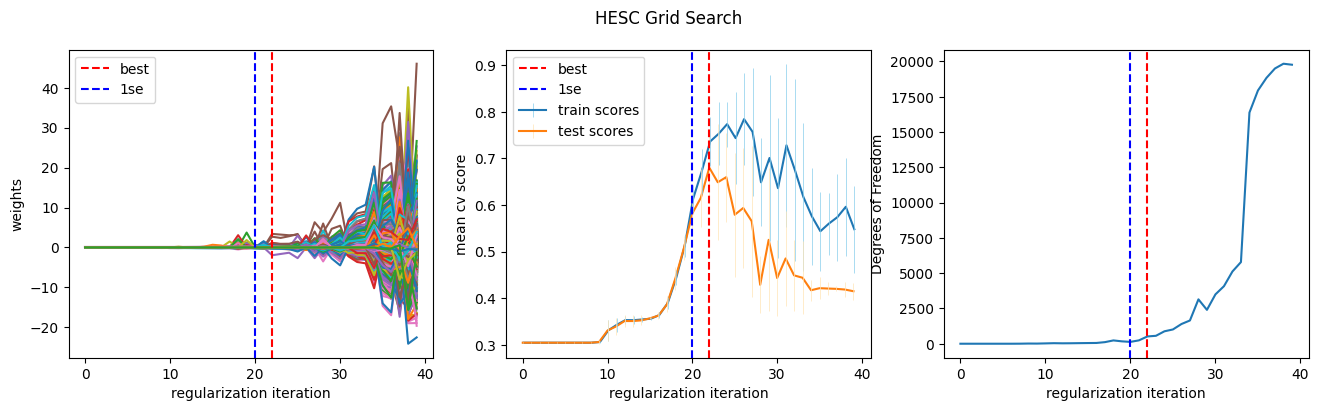

In [21]:
from psupertime.plots import plot_grid_search

_ = plot_grid_search(grid_search, title="HESC Grid Search")

Degrees of freedom 1
Train:
Accuracy: 0.721656976744186
Balanced accuracy: 0.7707304558997091
Mean absolute delta: 0.22985951460176576
Test:
Accuracy: 0.738562091503268
Balanced accuracy: 0.7901674268702373
Mean absolute delta: 0.2150957310244995


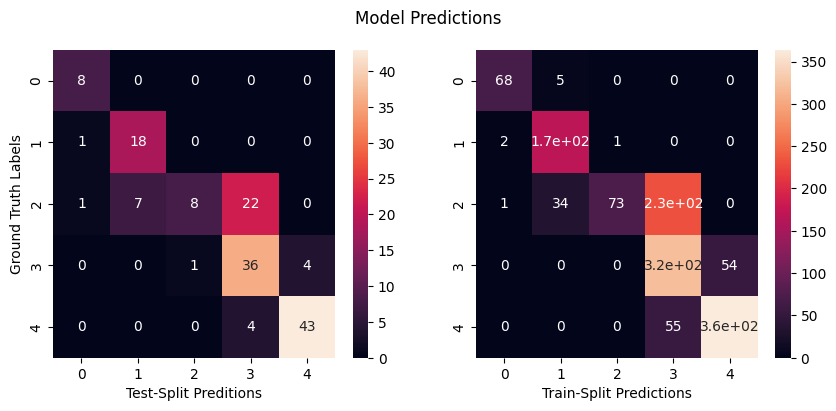

In [22]:
from psupertime.plots import plot_model_perf

model = grid_search.get_optimal_model("1se")
model.fit(X_train, y_train)

_ = plot_model_perf(model, test=(X_test, y_test), train=(X_train, y_train))

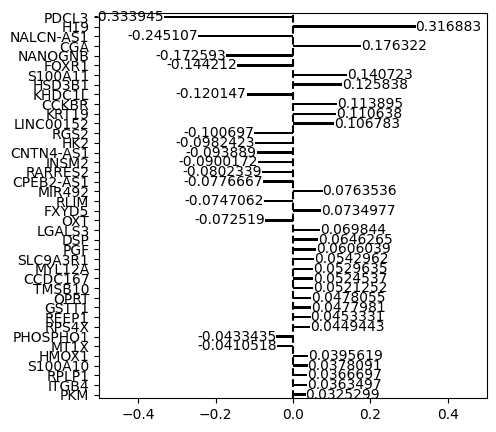

In [26]:
from masterthesis.plots import plot_identified_gene_coefficients

model.predict_psuper(anndata, inplace=True)
_ = plot_identified_gene_coefficients(model, anndata, n_top=40, figsize=(5,5))

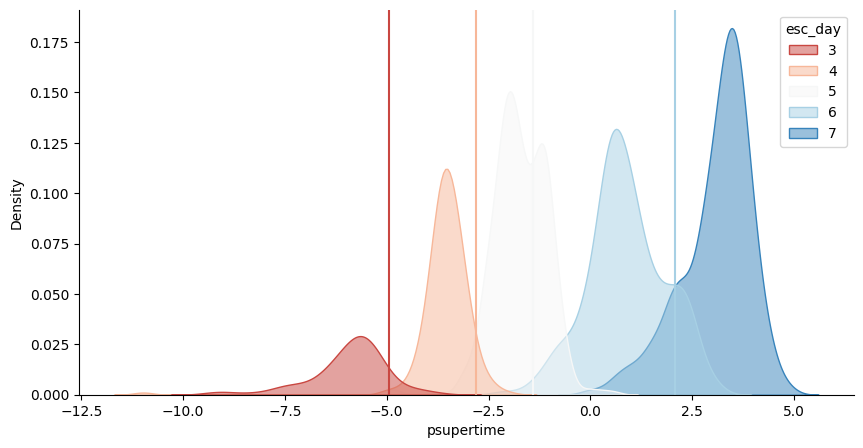

In [25]:
from masterthesis.plots import plot_labels_over_psupertime

_ = plot_labels_over_psupertime(model, anndata, "esc_day")